In [76]:
import numpy as np
import pandas as pd
from sko.ACA import ACA_TSP
from utils import parse_UK_Data, generate_coordinates
from scipy import spatial
import matplotlib.pyplot as plt
import time

# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
%config Completer.use_jedi = False

dataset = "../datasets/UK10_1.txt"


meta_data, distance_data, station_data = parse_UK_Data(dataset)

In [5]:
meta_data

,Customer Amount,Vehicle Curb Weight(kg),Max Load(kg),Minimum Speed(km/h),Maximum Speed(km/h)
0,10,6350,3650,20,90


In [6]:
distance_data

,0,1,2,3,4,5,6,7,8,9,10
0,0,41150,25680,54200,95380,15910,88960,74120,26010,88181,66070
1,40660,0,51980,32800,99870,42210,75660,63880,24350,72070,26250
2,25010,51780,0,61520,74050,12890,69270,52590,42910,73400,76700
3,54270,32750,61560,0,77030,51930,42930,31920,49480,39500,29500
4,94930,100030,74070,76930,0,81260,55600,46100,111960,61700,106350
5,15830,42600,12880,52340,81050,0,78000,61320,33730,82130,67520
6,88751,75700,69300,43030,55210,78040,0,17200,90550,6520,68800
7,73340,63440,52480,31830,46430,61220,17130,0,75520,21260,61250
8,25990,24350,43780,49530,111730,34010,90550,75740,0,88960,48920
9,88411,71740,73420,39430,61390,82160,6550,21320,88830,0,64010


In [7]:
station_data

,City Name,Demand(kg),Ready Time(sec),Due Time(sec),Service Time(sec)
0,Kingston_upon_Hull,0,0,32400,0
1,Pocklington,721,2171,22139,1442
2,Brough,814,644,21053,1628
3,Selby,620,1049,20424,1240
4,Boughton,311,5119,24241,622
5,Barton_upon_Humber,167,2338,21697,334
6,Darfield,513,3675,24120,1026
7,Bentley,568,4401,25046,1136
8,Watton,763,3485,24335,1526
9,Cudworth,558,3740,24049,1116


In [8]:
num_points = station_data.shape[0]
distance_matrix = distance_data.to_numpy()


def cal_total_distance(routine):
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

In [9]:
#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
#station_coordinates = generate_coordinates(station_data)
station_coordinates = pd.read_csv('../datasets/UK10_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "long"]].to_numpy()

In [10]:
aca = ACA_TSP(func=cal_total_distance, n_dim=11,
              size_pop=100, max_iter=200,
              distance_matrix=distance_matrix)

best_x, best_y = aca.run()


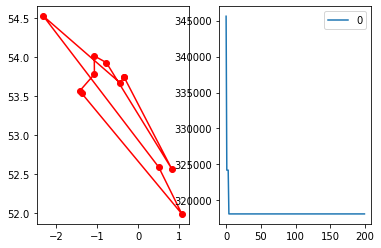

In [11]:
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_x, [best_x[0]]])
best_points_coordinate = points_coordinate[best_points_, :]
ax[0].plot(best_points_coordinate[:, 1], best_points_coordinate[:, 0], 'o-r')
pd.DataFrame(aca.y_best_history).cummin().plot(ax=ax[1])
plt.show()

In [79]:
import flexpolyline as fp
import requests
from tqdm import tqdm

api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

routes_encoded = []
with tqdm(total=10) as pbar:
    for i in range(10):
        response = requests.get("https://router.hereapi.com/v8/routes?transportMode=truck&origin=%f,%f&destination=%f,%f&return=polyline&apiKey=%s"
                               % (best_points_coordinate[i, 0], best_points_coordinate[i, 1],
                                 best_points_coordinate[i+1, 0], best_points_coordinate[i+1, 1],
                                 api))
        routes_encoded.append(response_json.get("routes")[0].get("sections")[0].get("polyline"))
        time.sleep(1)
        pbar.update()
            

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


In [72]:
response_json = response.json()

route_data = route.to_numpy()

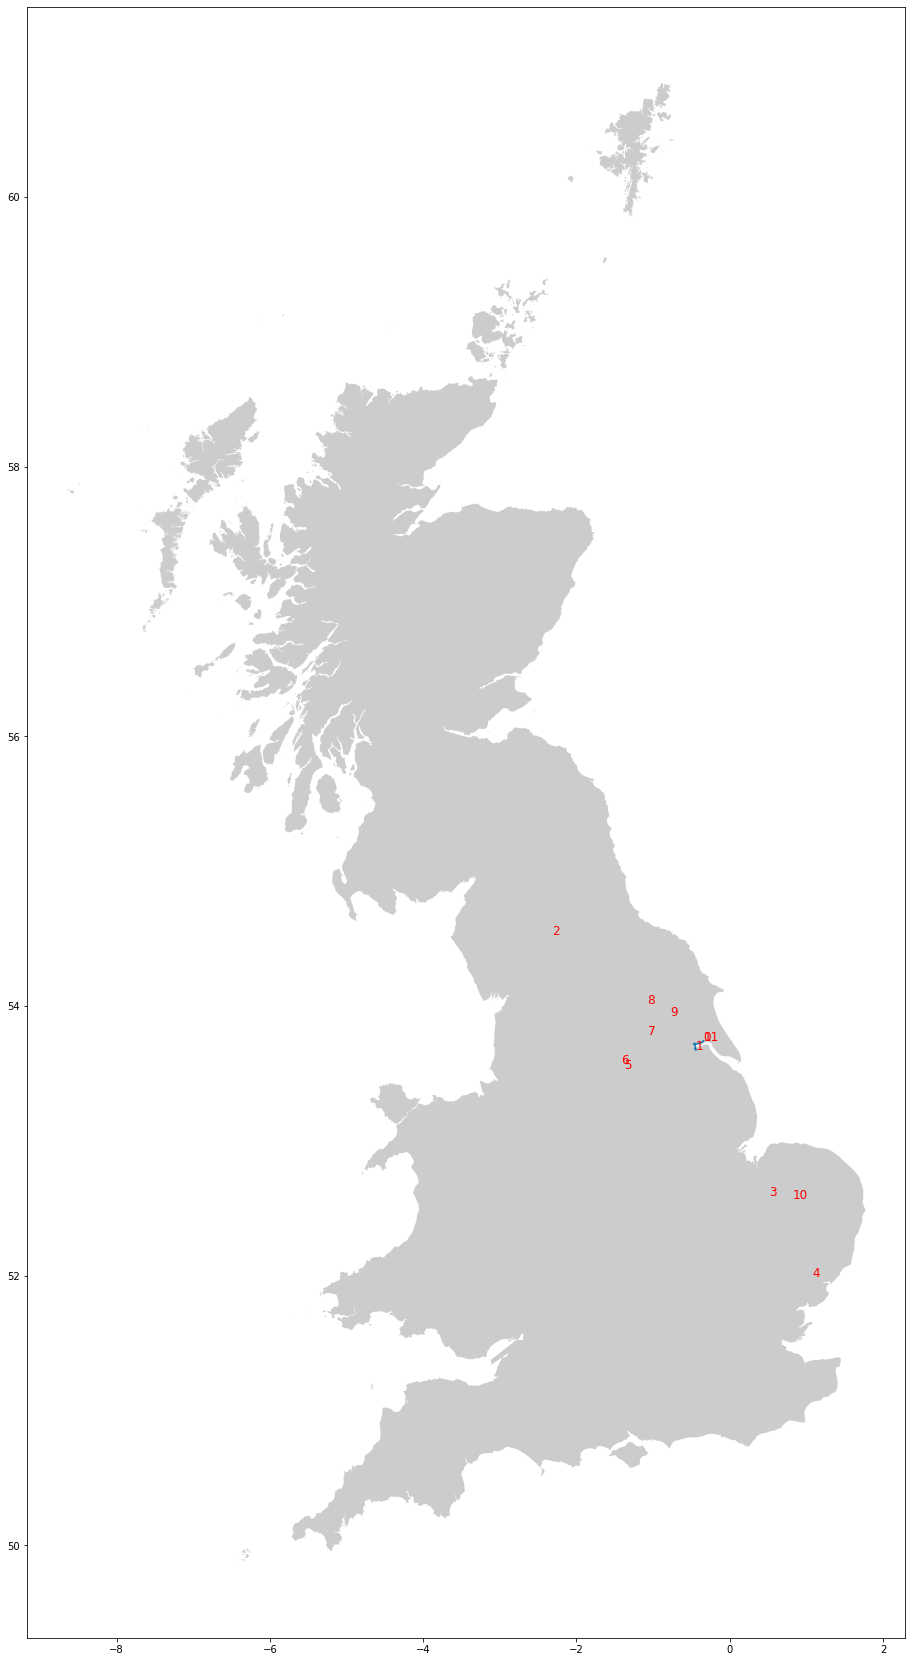

In [73]:
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt


UK = gpd.read_file("../datasets/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(30,30))# add .shp mapfile to axes
dbf.plot(ax=ax, alpha=0.4,color="grey")
#ax.plot(best_points_coordinate[:, 1], best_points_coordinate[:, 0])
ax.plot(route_data[:,1], route_data[:,0])
for i, (x, y) in enumerate(zip(best_points_coordinate[:, 1], best_points_coordinate[:, 0])):
    ax.text(x, y, str(i), color="red", fontsize=12)
